# Analyze Datasets for prediction of protein subceullar localization with 3D structure information

In [ ]:
#Dependencies

#Parsing sequences
!pip install Bio

# Install py3dmol.
%shell sudo apt install python3-pip
%shell pip3 install py3dmol

#Running MuLocDeep
#!pip install keras==2.3.0
#!pip install tensorflow==1.13.1 #https://www.tensorflow.org/install/source#gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.8 MB/s 
     |████████████████████████████████| 2.6 MB 45.0 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pkg-resources python3-secretstorage python3-setuptools python3-six
  python3-wheel python3-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python3-cryptography-vectors
  gnome-keyring libkf5wallet-bin gir1.2-gnomekeyring-1.0
  python-secretstorage-doc python-setuptools-doc
The following NEW packages will be installed:
  

In [ ]:
#Mount drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/BIOINF_590/Project Work')

Mounted at /content/drive


# Protein Localization Information:

This 2021 Review Paper (Computational methods for protein localization prediction) benchmarks multiple approaches against a common dataset (DeepLoc) which would be an excellent starting point
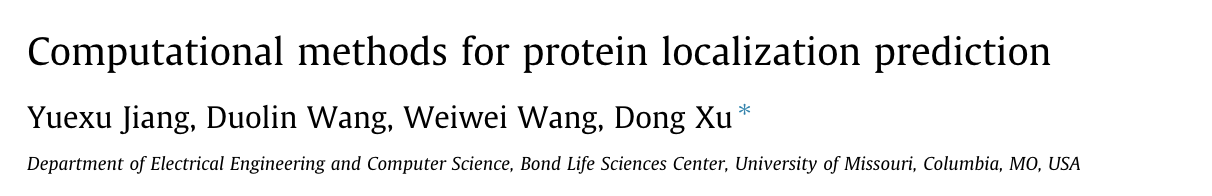

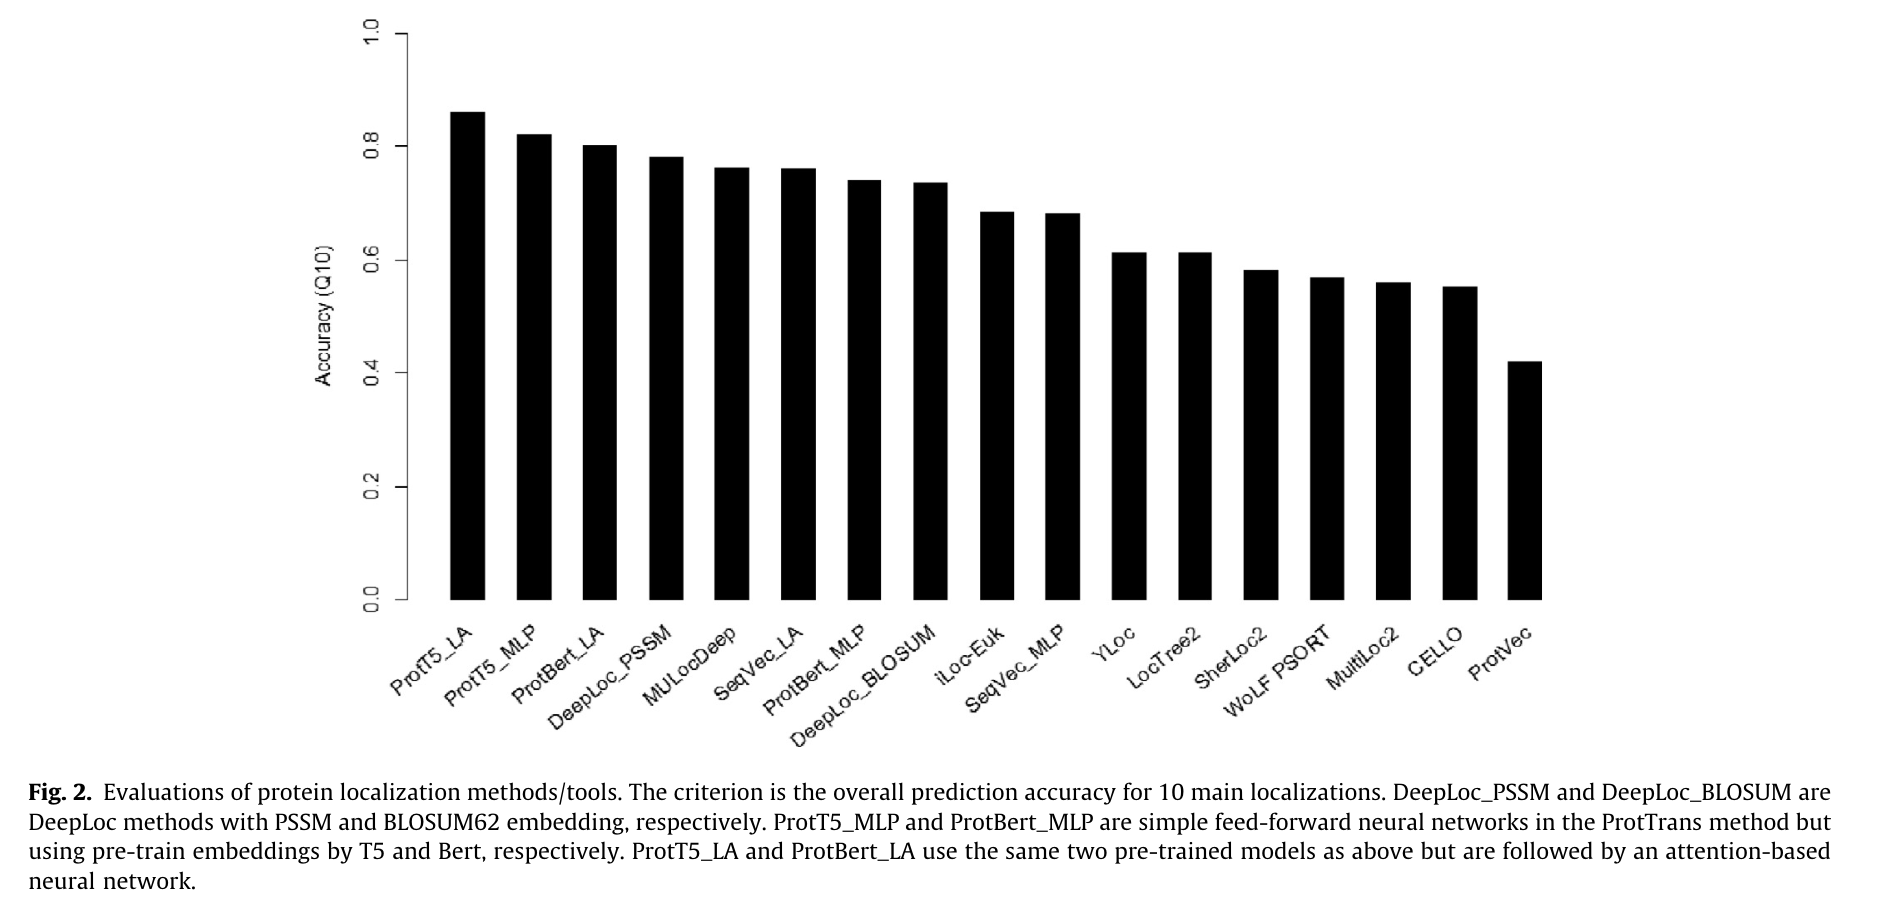

## The Deep Loc Dataset:
https://services.healthtech.dtu.dk/service.php?DeepLoc-1.0 

It is a fasta file composed by header and sequence. The header is composed by the accession number from Uniprot, the annotated subcellular localization and possibly a description field indicating if the protein was part of the test set. The subcellular localization includes an additional label, where S indicates soluble, M membrane and U unknown.

Example:
>Q3E7A9 Mitochondrion-S
MSNPCQKEACAIQDCLLSHQYDDAKCAKVIDQLYICCSKFYNDNGKDSRSPCCPLPSLLELKMKQRKLTPGDS
>Q9SMX3 Mitochondrion-M test
MVKGPGLYTEIGKKARDLLYRDYQGDQKFSVTTYSSTGVAITTTGTNKGSLFLGDVATQVKNNNFTADVKVST
DSSLLTTLTFDEPAPGLKVIVQAKLPDHKSGKAEVQYFHDYAGISTSVGFTATPIVNFSGVVGTNGLSLGTDV
AYNTESGNFKHFNAGFNFTKDDLTASLILNDKGEKLNASYYQIVSPSTVVGAEISHNFTTKENAITVGTQHAL>
DPLTTVKARVNNAGVANALIQHEWRPKSFFTVSGEVDSKAIDKSAKVGIALALKP

In [ ]:
#Parse fasta file with biopython
from Bio import SeqIO
dataset_fasta = 'data/deeploc/deeploc_data.fasta'

#Read all sequences as a biopython record
records = list(SeqIO.parse(dataset_fasta, "fasta"))
for record in records[0:10]:
    print(record, '\n')



ID: Q9H400
Name: Q9H400
Description: Q9H400 Cell.membrane-M test
Number of features: 0
Seq('MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGS...SLP') 

ID: Q5I0E9
Name: Q5I0E9
Description: Q5I0E9 Cell.membrane-M
Number of features: 0
Seq('MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFLAQLMMFLI...RTE') 

ID: P63033
Name: P63033
Description: P63033 Cell.membrane-M
Number of features: 0
Seq('MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFEDQYTPTIED...SIQ') 

ID: Q9NR71
Name: Q9NR71
Description: Q9NR71 Cell.membrane-M
Number of features: 0
Seq('MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGGHFFSTTQS...VTI') 

ID: Q86XT9
Name: Q86XT9
Description: Q86XT9 Cell.membrane-M
Number of features: 0
Seq('MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRTGLRSPDIP...TRL') 

ID: A2CI98
Name: A2CI98
Description: A2CI98 Cell.membrane-M
Number of features: 0
Seq('MDPSKQGTLNRVENSVYRTAFKLRSVQTLCQLDLMDSFLIQQVLWRGRSGESTE...PLV') 

ID: O75326
Name: O75326
Description: O75326 Cell.membrane-M
Number of features: 0
S

In [ ]:
#Combine data into pandas dataframe
import pandas as pd

#Dict for deeploc dataset information
deeploc_dict = {}

for idx, record in enumerate(records):
  #Extract information from record
  protein = record.name
  if '-' in protein:
    protein = protein.rsplit('-', 1)[0]
  print(idx, protein)
  sequence = ''.join(list(record.seq))
  description = record.description.split()
  location_info = description[1]
  if len(description) > 2:
    split_info = description[-1]
  else:
    split_info = 'train'
  location, extra = location_info.rsplit('-', 1)

  #Create dictionary
  deeploc_dict[idx] = {
        'Protein':protein,
        'Sequence':sequence,
        'Location':location,
        'Extra Location':extra,
        'Split':split_info,
    }
  
#Create pandas dataframe from dictionary
deeploc_df = pd.DataFrame(deeploc_dict).transpose()

#Drop location with Cytoplasm-Nucleus: (Now we have 13858 samples same as review paper)
deeploc_df = deeploc_df[~(deeploc_df['Location'] == 'Cytoplasm-Nucleus')]
deeploc_df = deeploc_df.reset_index(drop = True)
deeploc_df

 

In [ ]:
#Map locations to numeric label (0 - 9)
location_counts = deeploc_df['Location'].value_counts()
print(location_counts)
labels = dict(zip(location_counts.index, range(len(location_counts))))
deeploc_df['Location Label'] = deeploc_df['Location'].replace(labels).astype(float)
deeploc_df = deeploc_df.sort_values(by = ['Location Label'])
deeploc_df

Nucleus                  4043
Cytoplasm                2542
Extracellular            1973
Mitochondrion            1510
Cell.membrane            1340
Endoplasmic.reticulum     862
Plastid                   757
Golgi.apparatus           356
Lysosome/Vacuole          321
Peroxisome                154
Name: Location, dtype: int64


Protein                                           Sequence    Location  \
8557   P07834  MGSFPLAEFPLRDIPVPYSYRVSGGIASSGSVTALVTAAGTHRNSS...     Nucleus   
10700  Q9DA32  MPRTRNIGALCTLPEDTTHSGRPRRGVQRSYISRMAEPAPANMNDP...     Nucleus   
10701  O42927  MNPTSFIYDKPPPPPIINKPFEQTNSSASLTQKNSSSETENVGRHG...     Nucleus   
10702  Q38CE9  MVVLRPKITLTSVRGRIQVTAEDGERVGPWGGTECFLSRQTGQGPC...     Nucleus   
10703  Q06554  MSAVGALLAREYNVTAEKCDFFLENGSFDSVIAALPALNQEQETVT...     Nucleus   
...       ...                                                ...         ...   
11074  Q9LRS0  MEITNVTEYDAIAKAKLPKMVYDYYASGAEDQWTLQENRNAFARIL...  Peroxisome   
11073  A2AKK5  MMIKLIATPSNALVDEPVSIRATGLPPSQIVTIKATVKDENDNVFQ...  Peroxisome   
11072  Q02969  MSQFGTTDIVSGSETPPYSGASYQDAQDDNTHPHSSDAGAEKFSAG...  Peroxisome   
11079  O74936  MISPNLTANVEIDGKQYNTFTEPPKALAGERAKVKFPIKDMTEFLH...  Peroxisome   
11091  Q9LXS6  MEISQRVKARLAVLTAHLAVSDTVGLEQVLPAIAPWCTSAHITAAP...  Peroxisome   

      Extra Location  Split  Location Label  
8557               U  train             0.0  
10700              M  train             0.0  
10701              U   test             0.0  
10702              U  train             0.0  
10703              U  train             0.0  
...              ...    ...             ...  
11074              U  train             9.0  
11073              U  train             9.0  
11072              M  train             9.0  
11079              U  train             9.0  
11091              U  train             9.0  

[13858 rows x 6 columns]

In [ ]:
#Perform some exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns

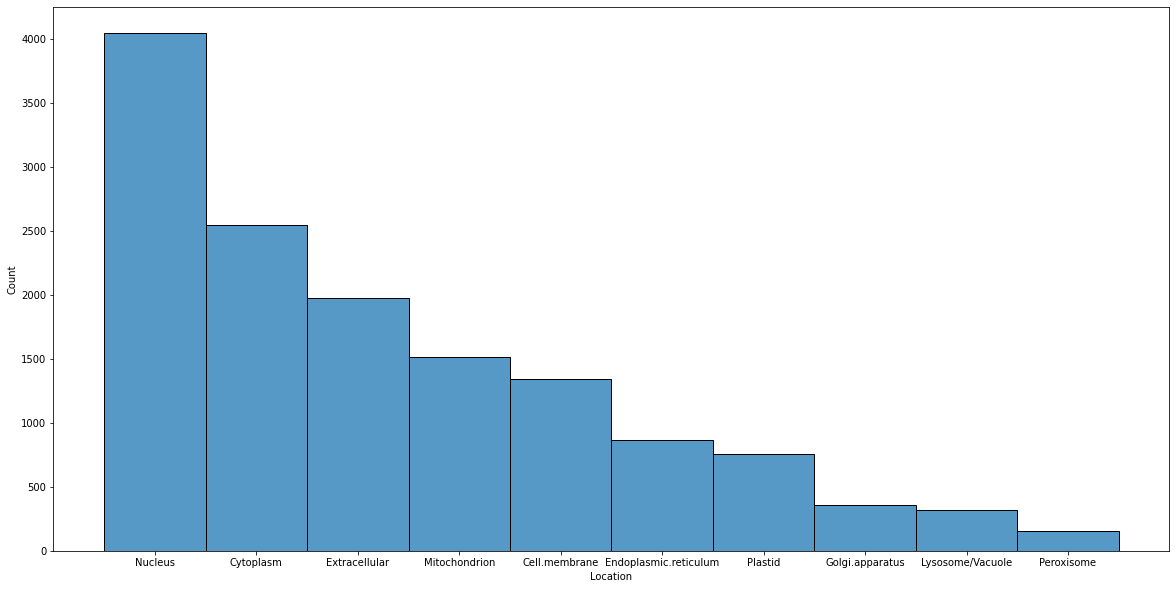

In [ ]:
#Plot different locations (takeaway: Drop Cytoplasm-Nucleus)
plt.figure(figsize = (20, 10))
sns.histplot(data = deeploc_df, x = 'Location')

Compare against figure from deeploc paper:
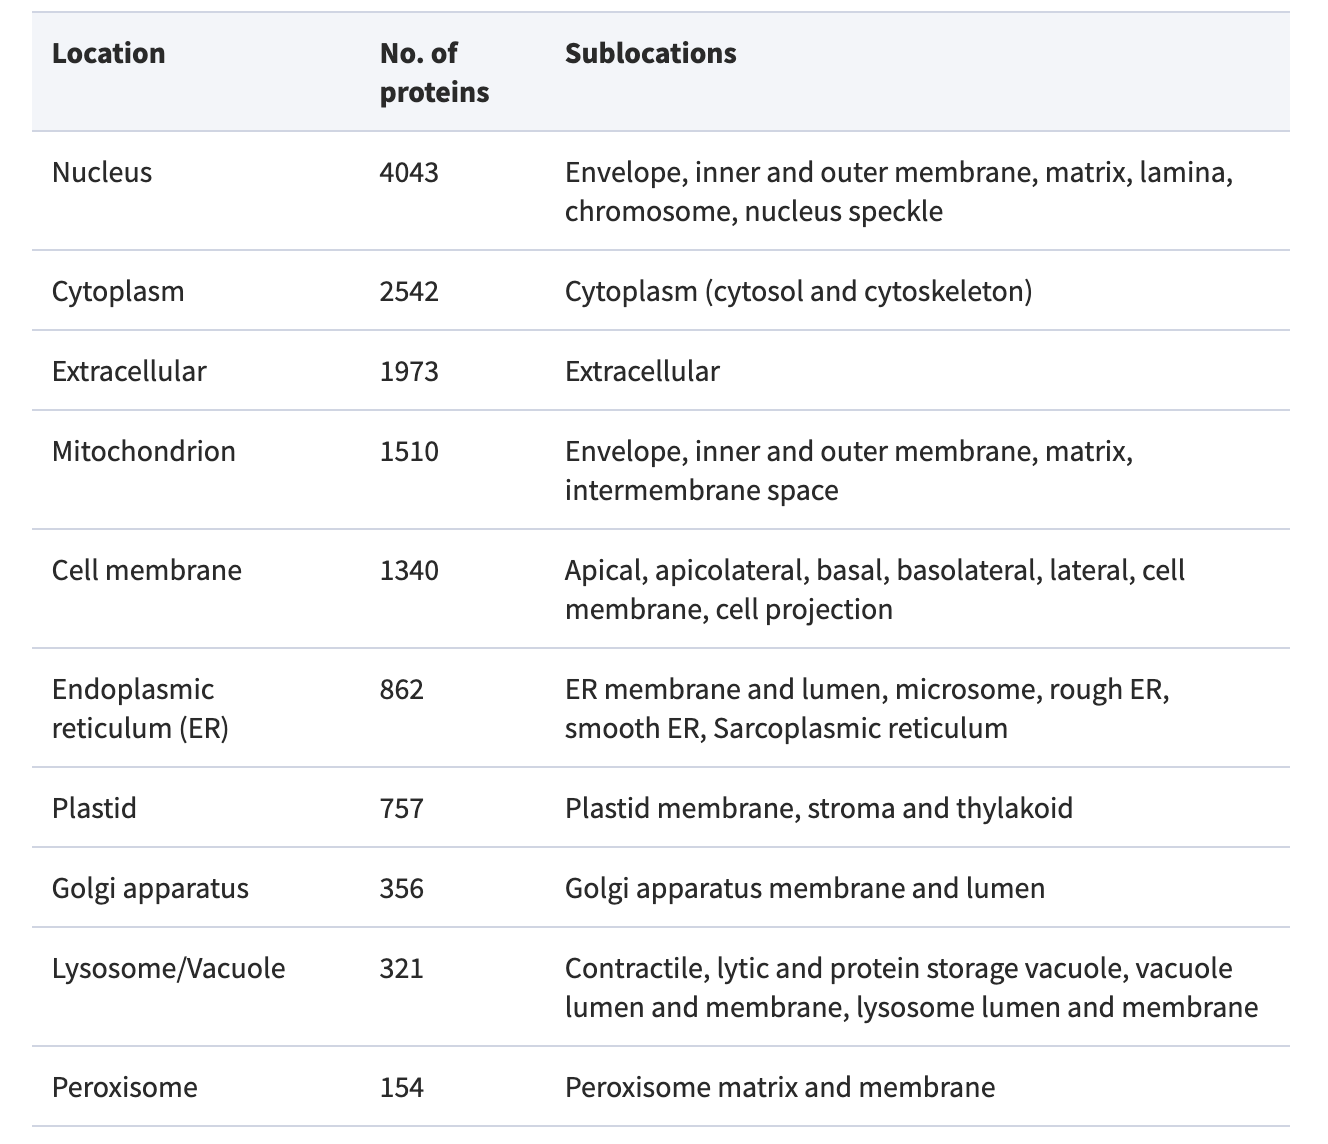

train    11085
test      2773
Name: Split, dtype: int64


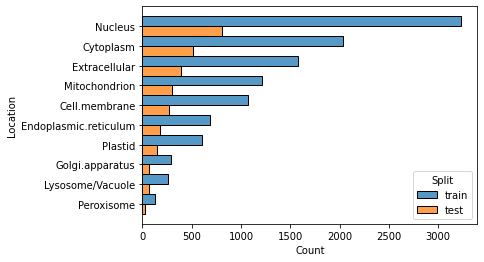

In [ ]:
#Look at location propensities against train and test data
sns.histplot(data = deeploc_df, y = 'Location', hue = 'Split', multiple = 'dodge')
print(deeploc_df['Split'].value_counts())

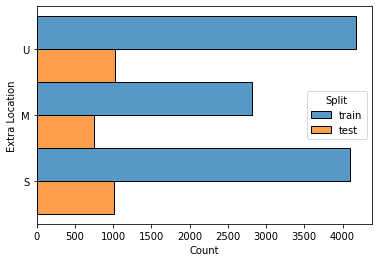

In [ ]:
#Plot extra location information
sns.histplot(data = deeploc_df, y = 'Extra Location', hue = 'Split', multiple = 'dodge')

(0.0, 2000.0)

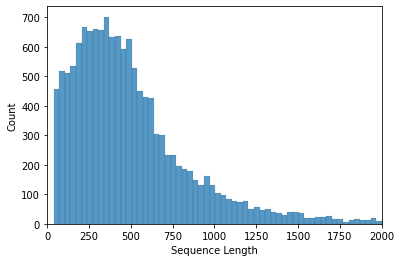

In [ ]:
#Plot mean sequence length
sequence_lengths = deeploc_df['Sequence'].apply(len)
sequence_lengths.name = 'Sequence Length'
sns.histplot(sequence_lengths)
plt.xlim(0, 2000)

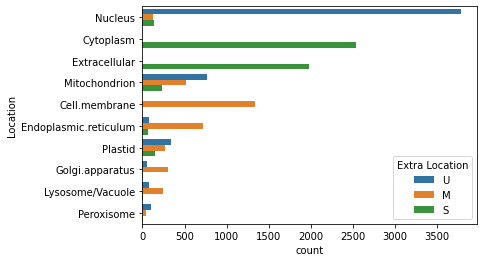

In [ ]:
#Plot location vs extra location information (could be multitask: soluble implies cytoplasm or extracellular, membrane implies cell membrane or mitochondrion or ER)
sns.countplot(data = deeploc_df, y = 'Location', hue = 'Extra Location')

In [ ]:
#Split data train, val, and test
from sklearn.model_selection import StratifiedKFold

test_data = deeploc_df[deeploc_df['Split'] == 'test'].reset_index(drop = True)
print('Test samples:', len(test_data))
train_val_data = deeploc_df[deeploc_df['Split'] == 'train'].reset_index(drop = True)

#Split into 4 train val sets:
skf = StratifiedKFold(n_splits=4, shuffle = True)
indices = skf.split(train_val_data['Protein'], train_val_data['Location Label'])
train_val_dfs = []
for fold, (train_indices, val_indices) in enumerate(indices):
  train_data = train_val_data.loc[train_indices]
  val_data = train_val_data.loc[val_indices]
  train_val_dfs.append([train_data, val_data])
  print(f'Fold: {fold} samples:', len(train_data), 'Val samples:', len(val_data))




Test samples: 2773
Fold: 0 samples: 8313 Val samples: 2772
Fold: 1 samples: 8314 Val samples: 2771
Fold: 2 samples: 8314 Val samples: 2771
Fold: 3 samples: 8314 Val samples: 2771


In [ ]:
#Check composition of fold and val samples
for fold, (train_df, val_df) in enumerate(train_val_dfs):
  print(fold)
  print('Train Location Counts')
  print(train_df['Location'].value_counts())
  #print(train_df)
  print('Val Location Counts')
  print(val_df['Location'].value_counts())

0
Train Location Counts
Nucleus                  2426
Cytoplasm                1525
Extracellular            1185
Mitochondrion             906
Cell.membrane             801
Endoplasmic.reticulum     516
Plastid                   454
Golgi.apparatus           215
Lysosome/Vacuole          192
Peroxisome                 93
Name: Location, dtype: int64
Val Location Counts
Nucleus                  809
Cytoplasm                509
Extracellular            395
Mitochondrion            302
Cell.membrane            266
Endoplasmic.reticulum    173
Plastid                  151
Golgi.apparatus           71
Lysosome/Vacuole          65
Peroxisome                31
Name: Location, dtype: int64
1
Train Location Counts
Nucleus                  2426
Cytoplasm                1526
Extracellular            1185
Mitochondrion             906
Cell.membrane             800
Endoplasmic.reticulum     517
Plastid                   453
Golgi.apparatus           215
Lysosome/Vacuole          193
Peroxisome    

In [ ]:
#Write out fasta seqence and label for evaluation of sequence based models
def write_df(df, datadir, name):
  #Save dataframe as excel
  df.to_excel(os.path.join(datadir, f'{name}.xlsx'))
  #Write out data as fasta format and labels for training other models
  fasta_file = os.path.join(datadir, f'{name}_fasta')
  label_file = os.path.join(datadir, f'{name}_label')
  with open(fasta_file, 'w') as fasta_writer:
    with open(label_file, 'w') as label_writer:
      for idx in df.index:
        protein = df['Protein'][idx]
        sequence = df['Sequence'][idx]
        label = df['Location Label'][idx]
        fasta_writer.write(f'>{protein}\n{sequence}\n')
        label_writer.write(f'{label}\n')
  return

#Save overall data
write_df(deeploc_df, 'data/deeploc', 'deeploc')

#Save train, validation, and testing data
datadir = 'data/deeploc/train_val_test'
write_df(test_data, datadir, 'test')
for fold, (train_df, val_df) in enumerate(train_val_dfs):
  write_df(train_df, datadir, f'train_{fold}')
  write_df(val_df, datadir, f'val_{fold}')



# Accessing 3D Structures with Big Query on AF2 Database
https://github.com/deepmind/alphafold/blob/main/afdb/README.md 


In [ ]:
#Create query
protein_list = [f'"{protein}"' for protein in deeploc_df['Protein']]
protein_tuple = f'({",".join(protein_list)})'
query = f'''
with file_rows AS (
  with file_cols AS (
    SELECT
      CONCAT(entryID, '-model_v4.cif') as m,
      CONCAT(entryID, '-predicted_aligned_error_v4.json') as p
    FROM bigquery-public-data.deepmind_alphafold.metadata
    WHERE uniprotAccession IN {protein_tuple}
    
  )
  SELECT * FROM file_cols UNPIVOT (files for filetype in (m, p))
)
SELECT CONCAT('gs://public-datasets-deepmind-alphafold-v4/', files) as files
from file_rows
'''

print(query)


with file_rows AS (
  with file_cols AS (
    SELECT
      CONCAT(entryID, '-model_v4.cif') as m,
      CONCAT(entryID, '-predicted_aligned_error_v4.json') as p
    FROM bigquery-public-data.deepmind_alphafold.metadata
    WHERE uniprotAccession IN ("P07834","Q9DA32","O42927","Q38CE9","Q06554","Q8TAS1","Q9UAS6","Q96WW3","O17828","Q8VYI0","Q9UBC1","O94573","Q9SZH4","Q01329","Q8IRB5","Q9YHE8","G5EBY0","Q12124","P40562","O00257","Q86SE9","P25368","O59741","Q60749","Q27365","Q8QFR2","Q9LKL2","Q9H0D6","F4K128","P50623","Q59E36","O94432","Q9NU22","Q9H1Z4","Q13285","O15047","Q9I8A3","Q6H668","P07250","Q9UBX2","O81851","O00255","Q9SAK5","P83266","Q9ESC7","Q5AP80","Q9P370","Q13247","Q9P374","P49723","Q9P347","P35875","Q9D494","O80678","Q8BLG0","O94667","P92965","Q9M9L6","P23025","Q9P7Z6","F1R5H6","O43013","P83916","Q9USR2","P38324","Q8CCK0","Q03214","Q08647","Q6INH0","P38326","Q07684","O74942","O94326","Q570C0","Q10222","Q921D9","Q9ESC8","O35144","Q9USR9","Q00416","Q9M658","O82743","Q9SU25","O

In [ ]:
#Read bigquery results
bg_results = 'data/deeploc_af2/bigquery_query.csv'
bg_df = pd.read_csv(bg_results)
print(bg_df)

                                                   files
0      gs://public-datasets-deepmind-alphafold-v4/AF-...
1      gs://public-datasets-deepmind-alphafold-v4/AF-...
2      gs://public-datasets-deepmind-alphafold-v4/AF-...
3      gs://public-datasets-deepmind-alphafold-v4/AF-...
4      gs://public-datasets-deepmind-alphafold-v4/AF-...
...                                                  ...
27367  gs://public-datasets-deepmind-alphafold-v4/AF-...
27368  gs://public-datasets-deepmind-alphafold-v4/AF-...
27369  gs://public-datasets-deepmind-alphafold-v4/AF-...
27370  gs://public-datasets-deepmind-alphafold-v4/AF-...
27371  gs://public-datasets-deepmind-alphafold-v4/AF-...

[27372 rows x 1 columns]


In [ ]:
#Download bigquery results with gsutil
from google.colab import auth
auth.authenticate_user()
!curl https://sdk.cloud.google.com | bash

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/surface/run/services/update_traffic.py
google-cloud-sdk/lib/surface/runtime_config/__init__.py
google-cloud-sdk/lib/surface/runtime_config/configs/__init__.py
google-cloud-sdk/lib/surface/runtime_config/configs/create.py
google-cloud-sdk/lib/surface/runtime_config/configs/delete.py
google-cloud-sdk/lib/surface/runtime_config/configs/describe.py
google-cloud-sdk/lib/surface/runtime_config/configs/list.py
google-cloud-sdk/lib/surface/runtime_config/configs/update.py
google-cloud-sdk/lib/surface/runtime_config/configs/variables/__init__.py
google-cloud-sdk/lib/surface/runtime_config/configs/variables/describe.py
google-cloud-sdk/lib/surface/runtime_config/configs/variables/get_value.py
google-cloud-sdk/lib/surface/runtime_config/configs/variables/list.py
google-cloud-sdk/lib/surface/runtime_config/configs/variables/set.py
google-cloud-sdk/lib/surface/runtime_config/configs/variables/unset.py
google-cloud-sdk/lib/surfa

In [ ]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
core:
  account: azamh@umich.edu

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you would like to use to perform operations for this 
configuration:
 [1] azamh@umich.edu
 [2] Log in with a new account
Please enter your numeric choice:  1

You are logged in as: [azamh@umich.edu].

Pick cloud project to use: 
 [1] localizationaf
 [2] Enter a project ID
 [3] Create a new project
Please

In [ ]:
#Download all AF2 predictions https://cloud.google.com/storage/docs/gsutil/commands/cp 
#!cat data/deeploc_af2/bigquery_query.csv | gsutil -m cp -n -I data/deeploc_af2/ 

In [ ]:
#Get PDB file for each protein
protein_pdb_dict = dict()
count = 0 
for protein in deeploc_df['Protein']:
  protein = protein.split('-')[0]
  pdb_file = f'data/deeploc_af2/AF-{protein}-F1-model_v4.cif'
  if not os.path.isfile(pdb_file):
    print(f'NO PDB FOR {protein}')
    count += 1
  else:
    protein_pdb_dict[protein] = os.path.abspath(pdb_file)
  
print('N MISSING:', count)


NO PDB FOR Q9NU22
NO PDB FOR Q9P347
NO PDB FOR P0CW71
NO PDB FOR Q8TD26
NO PDB FOR Q96T58
NO PDB FOR Q93442
NO PDB FOR Q9Y4A5
NO PDB FOR H2QII6
NO PDB FOR Q5SNT2
NO PDB FOR G5EEV2
NO PDB FOR E9QAM5
NO PDB FOR Q03280
NO PDB FOR Q8SX83
NO PDB FOR Q7YZH1
NO PDB FOR Q03164
NO PDB FOR Q9P2D1
NO PDB FOR P21359
NO PDB FOR P38110
NO PDB FOR Q8IV76
NO PDB FOR Q12019
NO PDB FOR Q62504
NO PDB FOR O75592
NO PDB FOR Q9UTM3
NO PDB FOR P20659
NO PDB FOR Q9NDJ2
NO PDB FOR Q8IN94
NO PDB FOR P63016
NO PDB FOR P46013
NO PDB FOR P49792
NO PDB FOR Q20497
NO PDB FOR Q08619
NO PDB FOR P29692
NO PDB FOR O75691
NO PDB FOR Q24119
NO PDB FOR O94248
NO PDB FOR O15381
NO PDB FOR Q91XR9
NO PDB FOR Q91XR8
NO PDB FOR P78527
NO PDB FOR Q6ZRS2
NO PDB FOR Q63HN8
NO PDB FOR O95613
NO PDB FOR Q5TBA9
NO PDB FOR Q99MV5
NO PDB FOR Q0KL02
NO PDB FOR O60229
NO PDB FOR Q5VST9
NO PDB FOR A8ICS9
NO PDB FOR P51161
NO PDB FOR Q9VCA8
NO PDB FOR Q6NYC8
NO PDB FOR Q8WUY3
NO PDB FOR Q5VWZ2
NO PDB FOR P18963
NO PDB FOR A8J666
NO PDB FOR

In [ ]:
print(protein_pdb_dict)

{'P07834': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-P07834-F1-model_v4.cif', 'Q9DA32': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q9DA32-F1-model_v4.cif', 'O42927': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-O42927-F1-model_v4.cif', 'Q38CE9': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q38CE9-F1-model_v4.cif', 'Q06554': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q06554-F1-model_v4.cif', 'Q8TAS1': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q8TAS1-F1-model_v4.cif', 'Q9UAS6': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q9UAS6-F1-model_v4.cif', 'Q96WW3': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q96WW3-F1-model_v4.cif', 'O17828': '/content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-O17828-F1-model_v4.cif', 'Q8VYI0': '/content/drive/S

## Visuallize 3D structure

In [ ]:
#Visuallize example protein
import py3Dmol
protein, pdb_path = list(protein_pdb_dict.items())[0]
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', linked=False)
view.addModel(open(pdb_path,'r').read(),'cif')
view.setStyle({'model':0}, {'cartoon': {'color': 'orange'}})
view.zoomTo({'model':0})
#view.setStyle({'model':0}, {'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}}) #color by bfactor

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Generate contact map for graph representation

In [ ]:
#Create contact map for protein http://biopython.org/DIST/docs/tutorial/Tutorial.html 
#https://en.wikipedia.org/wiki/Protein_contact_map 
from Bio.PDB.MMCIFParser import MMCIFParser
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

#Threshold for contact
threshold = 10.0

def cmap(protein, pdb_path, format = 'cif'):
  print(protein, pdb_path)

  #Parse protein CA atoms with biopython and store in numpy array
  ca_coord_list = []
  parser = MMCIFParser()
  structure = parser.get_structure(protein, pdb_path)[0]['A']
  for residue in structure.get_list():
    if residue.has_id("CA"):
      ca = residue["CA"]
      ca_coord_list.append(ca.get_coord())
  ca_coord_array = np.array(ca_coord_list)
  #print(ca_coord_array)

  #Get distance matrix
  cmap = euclidean_distances(ca_coord_array, ca_coord_array)

  #Assign contacts based on threshold
  cmap[cmap < threshold] = 1
  cmap[cmap > threshold] = 0
  
  return cmap

#Generate cmaps for first 100 
cmaps = [cmap(protein, protein_pdb) for protein, protein_pdb in list(protein_pdb_dict.items())[0:100]]
print(len(cmaps))

P07834 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-P07834-F1-model_v4.cif
Q9DA32 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q9DA32-F1-model_v4.cif
O42927 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-O42927-F1-model_v4.cif
Q38CE9 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q38CE9-F1-model_v4.cif
Q06554 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q06554-F1-model_v4.cif
Q8TAS1 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q8TAS1-F1-model_v4.cif
Q9UAS6 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q9UAS6-F1-model_v4.cif
Q96WW3 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q96WW3-F1-model_v4.cif
O17828 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-O17828-F1-model_v4.cif
Q8VYI0 /content/drive/Shareddrives/BIOINF_590/Project Work/data/deeploc_af2/AF-Q8V

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


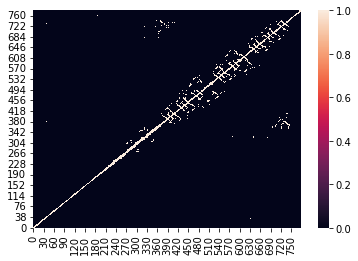

In [ ]:
#Show example contact map
print(cmaps[0])
sns.heatmap(cmaps[0])
plt.gca().invert_yaxis()

### Compare against NCBI example
https://www.ncbi.nlm.nih.gov/Structure/icn3d/full.html?mmdbid=1kq2&date=20210630&v=3.2.3&command=contact+map+%7C+dist+8+%7C+type+cbeta;+contactmap+scale+0.08%7C%7C%7C%7B%22factor%22:%221.000%22,%22mouseChange%22:%7B%22x%22:%220.000%22,%22y%22:%220.000%22%7D,%22quaternion%22:%7B%22_x%22:%220.000%22,%22_y%22:%220.000%22,%22_z%22:%220.000%22,%22_w%22:%221.000%22%7D%7D
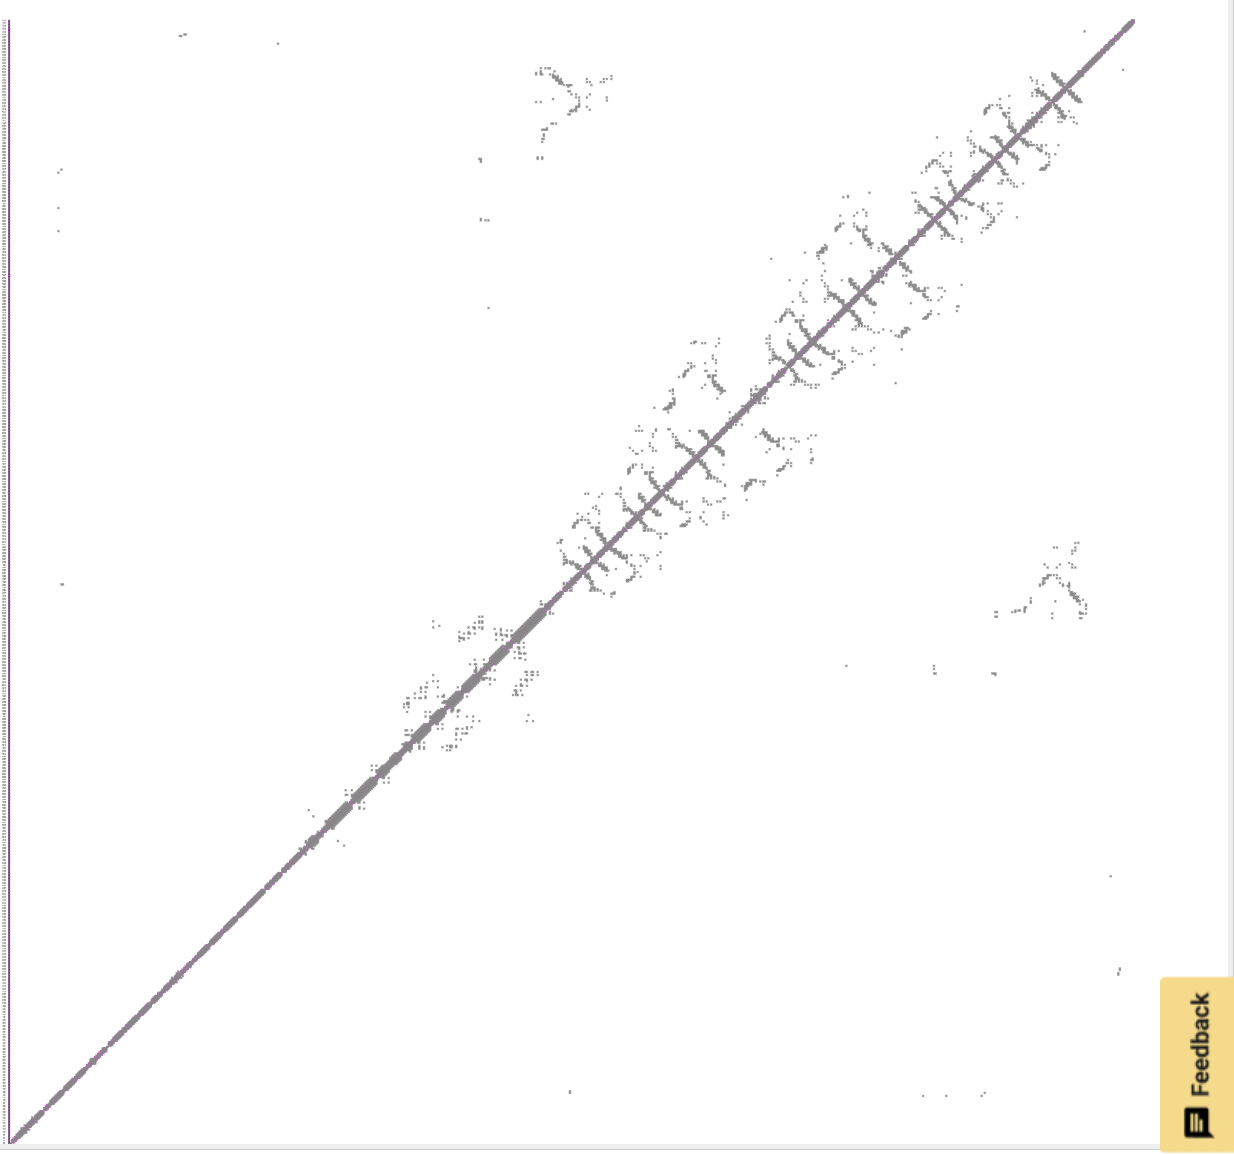

# EXAMPLES:

## Train Graph Convolutional Neural Network with TF
https://github.com/tensorflow/gnn
https://github.com/tensorflow/gnn/blob/main/examples/notebooks/intro_mutag_example.ipynb

In [ ]:
!pip install tensorflow_gnn

In [ ]:
import tensorflow as tf
import tensorflow_gnn as tfgnn

#In our case: atom (nodes) labeled with atom type (C, CA, CB, N, O)
#bonds = contacts (edges) determined by contact map

## Train LSTM + Graph Convolutional Neural Network (Deep Fri)
https://github.com/flatironinstitute/DeepFRI 

In [ ]:
#!git clone https://github.com/flatironinstitute/DeepFRI

In [ ]:
#os.chdir('/content/drive/Shareddrives/BIOINF_590/Project Work/DeepFRI')
#!pip install .
#!pip install obonet

In [ ]:
#Modify train_DeepFri.py
#import csv
#import json
#import pickle

#import argparse
#import numpy as np

#from deepfrier.DeepFRI import DeepFRI
#from deepfrier.utils import *
#from deepfrier.utils import load_GO_annot, load_EC_annot

In [ ]:
#Train graph CNN without LSTM model
#graph_conv_dims=[512,512,512]
#fully_connected_dims=[1024]
#graph_conv_layer='GraphConv'
#cmap_thresh=10.0
#cmap_data="PDB" # possible: PDB, SWISS-MODEL or MERGED
#l2 = 2 * 10 ** -5
#output_dim = 10
#lr = 0.0002
#dropout = 0.3


#model = DeepFRI(output_dim=output_dim, n_channels=26, gc_dims=graph_conv_dims, fc_dims=fully_connected_dims,
#                    lr=lr, drop=dropout, l2_reg=l2, gc_layer=graph_conv_layer,
#                    lm_model_name=None, model_name_prefix='GraphLocalizer')

In [ ]:
#Create cmaps for every protein
#os.chdir('preprocessing')
#from PDB2distMap import *
#for protein, pdb_path in protein_pdb_dict.items():
#  print(make_distance_maps(pdb_path))
#  print(protein, pdb_path)

## Train and Test MuLocDeep with benchmark data (2021 Method)

In [ ]:
#!git clone https://github.com/yuexujiang/MULocDeep


In [ ]:
#!PATH="/content/drive/Shareddrives/BIOINF_590/Project Work/MULocDeep/ncbi-blast-2.9.0+:$PATH"
#!chmod +x "/content/drive/Shareddrives/BIOINF_590/Project Work/MULocDeep/ncbi-blast-2.9.0+"/*
#os.chdir('/content/drive/Shareddrives/BIOINF_590/Project Work/MULocDeep')
#!"/content/drive/Shareddrives/BIOINF_590/Project Work/MULocDeep/ncbi-blast-2.9.0+/bin/blastp"

In [ ]:
#Train.py imports for MuLocDeep
#import os
#import tensorflow as tf
#from keras.callbacks import EarlyStopping, ModelCheckpoint
#from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
#import math
#from itertools import product
#import argparse
#import sys
#from utils import *
#from train import
#import calendar
#import time

In [ ]:
#Slightly modify training to work with our dataset
#Old: 
'''
def train_var(input_var,pssm_dir,output_dir,foldnum):
    # get small data
    [train_x,train_y,train_mask,train_ids]=endpad(input_var+"deeploc_40nr_train_fold"+str(foldnum)+"_seq",
                                        input_var+"deeploc_40nr_train_fold"+str(foldnum)+"_label",
                                        pssm_dir,
                                        "./data/npzfiles/train_fold"+str(foldnum)+"_seq.npz")
    [val_x,val_y,val_mask,val_ids]=endpad(input_var+"deeploc_40nr_val_fold"+str(foldnum)+"_seq",
                                  input_var+"deeploc_40nr_val_fold"+str(foldnum)+"_label",
                                  pssm_dir,
                                  "./data/npzfiles/val_fold"+str(foldnum)+"_seq.npz")
    batch_size = 128
    print("doing " + str(foldnum) + "th fold")
    model = var_model(train_x)

    filepath_acc = output_dir+"fold" + str(
        foldnum) + "acc-weights.hdf5"  # -improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
    checkpoint_acc = ModelCheckpoint(filepath_acc, monitor='val_accuracy', save_best_only=True, mode='max',
                                 save_weights_only=True, verbose=1)
    fitHistory_batch = model.fit([train_x,train_mask.reshape(-1,1000,1)],getTrue4out1(train_y),
                                 batch_size=batch_size, epochs=60,
                                 validation_data=([val_x,val_mask.reshape(-1,1000,1)], getTrue4out1(val_y)),
                                 callbacks=[checkpoint_acc],verbose=1)
'''


'\ndef train_var(input_var,pssm_dir,output_dir,foldnum):\n    # get small data\n    [train_x,train_y,train_mask,train_ids]=endpad(input_var+"deeploc_40nr_train_fold"+str(foldnum)+"_seq",\n                                        input_var+"deeploc_40nr_train_fold"+str(foldnum)+"_label",\n                                        pssm_dir,\n                                        "./data/npzfiles/train_fold"+str(foldnum)+"_seq.npz")\n    [val_x,val_y,val_mask,val_ids]=endpad(input_var+"deeploc_40nr_val_fold"+str(foldnum)+"_seq",\n                                  input_var+"deeploc_40nr_val_fold"+str(foldnum)+"_label",\n                                  pssm_dir,\n                                  "./data/npzfiles/val_fold"+str(foldnum)+"_seq.npz")\n    batch_size = 128\n    print("doing " + str(foldnum) + "th fold")\n    model = var_model(train_x)\n\n    filepath_acc = output_dir+"fold" + str(\n        foldnum) + "acc-weights.hdf5"  # -improvement-{epoch:02d}-{val_loss:.2f}.hdf5"\n    che

# TODO

*   Get other datasets in most recent papers
*   Maybe incorporate HPA/Comparments/Mito3 data
*   Setup bencmhark and validate results of review with various models
*   Implement graph CNN with contact maps
*   Implement 3d CNN with grid representation
*   Implement transformer architecture on sequence
*   Experiment with fusion / multi task (Soluble, Insoluble, Unknown [there are predictors of protein solubility])






